# Sediment Erosion

In this notebook we implement the erosion components of the matlab model (Mariotti and Murshid, 2018) in the existing landlab tidal flow version.

## Importing and Installing

First we will import some standard scientific Python libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Next we need to install some Landlab libraries to properly accomplish this task

As of this writing (8/18/2020) the tidal-flow-calculator is not part of the core Landlab installation. As a consequence, we need to checkout the feature branch containing the tidal-flow-calculator component (https://github.com/landlab/landlab/tree/gt/tidal-flow-component). After checking out or cloning this branch locally, python setup.py install should be run to build a new landlab installation containing the tidal-flow-calculator.

We convert the matlab fuctions (totalsedimenterosionMUDsine.m) from Mariotti and Murshid ( 2018) to python (tidal_erosion_calculator) to calculate total sediment erosion. 

In [2]:
from landlab.grid.mappers import map_link_vector_components_to_node
from landlab import RasterModelGrid, imshow_grid
from landlab.components import TidalFlowCalculator
from landlab.grid.mappers import map_max_of_link_nodes_to_link
from landlab.io import read_esri_ascii
import tidal_erosion_calculator as tec

## Set parameters 

In [14]:
#This set-up is from the MarshMorpho2D source code
tidal_period = 12.5 * 3600.0  # tidal period in seconds
tidal_range = 3.1  # tidal range in meters
roughness_w = 0.02  # Manning's n water
roughness_v = 0.2 #manning's n for veg
mean_sea_level = 0.0  # mean sea level in meters
mwd = 0.01  # minimum depth for water on areas higher than low tide water surface, meters
nodata_code = 999  # code for a DEM cell with no valid data
tcrgradeint = 0.2; # linear increase in tcr below MLW [pa/m]; not used in current version

### Read the DEM to create a grid and topography field

The zSW3.asc dataset can be found at: https://raw.githubusercontent.com/landlab/landlab/gt/tidal-flow-component/notebooks/tutorials/tidal_flow/zSW3.asc or the CostalTeam github repository. 

In [15]:
(grid, z) = read_esri_ascii('/Users/ningjiehu/zSW3.asc.txt', name='topographic__elevation')

### Create vegetation grid

In [16]:
veg = grid.add_zeros('vegetation',at='node');
veg[z<0] = 1;
veg_atlink = grid.map_max_of_link_nodes_to_link('vegetation')
grid.add_field('veg_atlink',veg_atlink,at='link')

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

### Configure boundaries

The boundaries contains any nodata nodes, plus any nodes higher than mean high tide

In [17]:
grid.status_at_node[z==nodata_code] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[z>1.8] = grid.BC_NODE_IS_CLOSED
boundaries_above_msl = np.logical_and(grid.status_at_node==grid.BC_NODE_IS_FIXED_VALUE, z > 0.0)
grid.status_at_node[boundaries_above_msl] = grid.BC_NODE_IS_CLOSED

print('pre tfc:')
print(grid.at_node.keys())
print(grid.at_link.keys())

pre tfc:
['topographic__elevation', 'vegetation']
['veg_atlink']


### Generate variable rougness as field in grid

In [18]:
roughness_at_nodes = roughness_w + np.zeros(z.size)
roughness_at_nodes[z < 0.0] = roughness_v #or roughness_at_nodes[veg] = roughness_v
roughness = grid.add_zeros('roughness', at='link')
map_max_of_link_nodes_to_link(grid, roughness_at_nodes, out=roughness)

array([ 0.02,  0.02,  0.02, ...,  0.02,  0.02,  0.02])

## Instantiate a TidalFlowCalculator component

In [19]:
tfc = TidalFlowCalculator(
        grid,
        tidal_period=tidal_period,
        tidal_range=tidal_range,
        roughness='roughness',
        mean_sea_level=mean_sea_level,
        min_water_depth=mwd,
)

tfc.run_one_step()
print(grid.at_node.keys())

['topographic__elevation', 'vegetation', 'mean_water__depth']


### Assign critical shear stress

In [20]:
tau_cr = 0.2 #Critical stress for unvegetated areas
tau_crv = 0.5  #Critical stress for vegetated areas

### Create grids

In [21]:
v = grid.at_link['veg_atlink']
tec.populateGrids(grid,tfc,tau_cr,tau_crv,v)

### Set mud erodability

In [22]:
mud_erodability = (10**-5);  # mud erodability kg/m2/s

## Run a single erosion step

note this just calculate erosion as a rate, does not update grids

In [25]:
ero = tec.totalsedimenterosion_mudsine(grid, mud_erodability, tidal_range, tcrgradeint)
print(ero)
print(ero.mean())

[ 0.  0.  0. ...,  0.  0.  0.]
4.49564123904e-06


### Save original bathy & topo maps

In [26]:
x = grid.at_node['topographic__elevation'].copy()
grid.add_field('Initial_topographic_elevation',x,at='node')
y = grid.at_node['mean_water__depth'].copy()
grid.add_field('Initial_mean_water_depth',y,at='node')

array([ 0.01,  0.01,  0.01, ...,  0.01,  0.01,  0.01])

## Run erosion over timesteps

Now we can do "psuedo morphodynamics", which allow erosion to happen in cells, but no sed. transport, no deposition.
- In this step, the model will step through erosion calculation, calculate the new bed elevation, recalculate the hydrodynamics, and update grids
- We can plot every 20 th step, and outputs the minimum bed elevation every step

### Plot topographic elevation

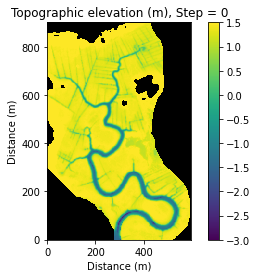

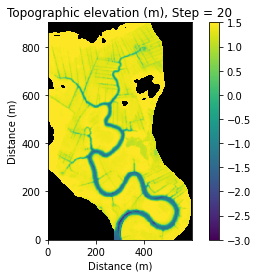

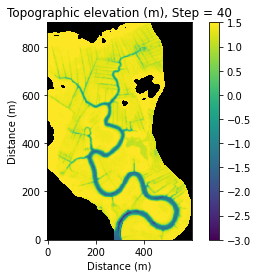

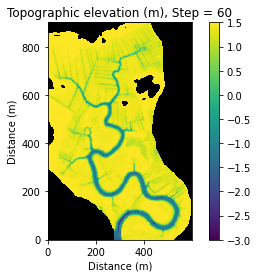

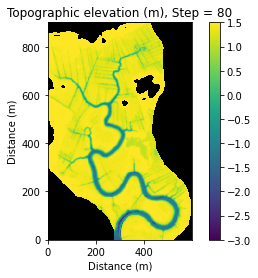

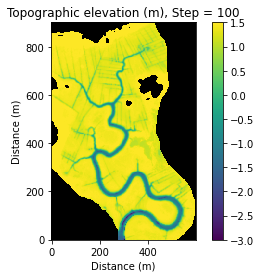

In [28]:
for i in range(101):
    ero = tec.totalsedimenterosion_mudsine(grid, mud_erodability, tidal_range, tcrgradeint)
    ero *= tidal_period/2 * 1/2650 #calc erosion over half the tidal cycle converting
    #print('ero mean: ' + str(ero.mean()))
    #print('ero max: ' +str(ero.max()))
    #print('z min: ' +str(z.min()))
    z = grid.at_node['topographic__elevation']
    z -= ero #update bed elevation
    #print('z min post erosion: ' +str(z.min()))
    tfc.run_one_step()
    tec.updategrids(grid,tfc)  
    
    if i%20==0:
        plt.figure()
        imshow_grid(grid,grid.at_node['topographic__elevation'], vmin = -3, vmax = 1.5, cmap = 'viridis')
        plt.title('Topographic elevation (m), Step = ' + str(i))
        plt.xlabel('Distance (m)')
        plt.ylabel('Distance (m)')

### Plot final water depths

Text(0, 0.5, 'Distance (m)')

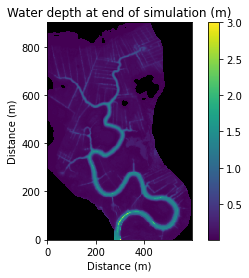

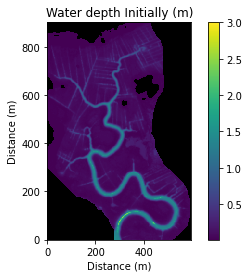

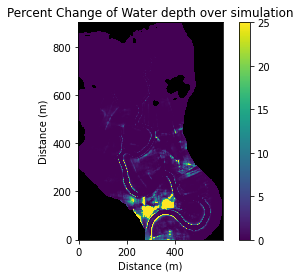

In [29]:
plt.figure()
imshow_grid(grid, grid.at_node['mean_water__depth'], cmap='viridis', color_for_closed='k',vmax=3)
plt.title('Water depth at end of simulation (m)')
plt.xlabel('Distance (m)')
plt.ylabel('Distance (m)')

plt.figure()
imshow_grid(grid, grid.at_node['Initial_mean_water_depth'], cmap='viridis', color_for_closed='k',vmax=3)
plt.title('Water depth Initially (m)')
plt.xlabel('Distance (m)')
plt.ylabel('Distance (m)')

plt.figure()
g =  grid.at_node['mean_water__depth'].copy();
go = grid.at_node['Initial_mean_water_depth'].copy();
gper = (g-go)/go * 100
grid.add_field('Percent Change water depth',gper,at='node',clobber=True)
imshow_grid(grid, grid.at_node['Percent Change water depth'], cmap='viridis', color_for_closed='k',vmax=25)
plt.title('Percent Change of Water depth over simulation')
plt.xlabel('Distance (m)')
plt.ylabel('Distance (m)')

# Questions to think about

1. Now you can see where there is high erosion occuring - why might this spot have erosion? What might change the pattern and location of erosion?

2. What variables can you change or play with to produce a different response in this landscape?

3. What are key things missing from this model? What are we not modeling?

4. looking at the percent change in water level is helpful. How can you look at percent change of elevation or flood velocities in the landscape? What code would need to be added?